### Фильтрация пейзажных фотографий

1. Оставляем только фотографии соответствеющие интересующим нас классам. 
2. Затем дополнительно отфильтровываем изображения, содержащие фигуры и лица людей.

In [142]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable as V
from torch.nn import functional as F

from PIL import Image,  UnidentifiedImageError
import matplotlib.pyplot as plt
import numpy as np
import os

#### Модель для фильтрации по классам

Используем стороннее решение - предобученную на датасете Places365 модель ResNet. Загружаем веса и общий список классов.

In [131]:
arch = 'resnet18'

model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)
    
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
print('Loaded pretrained model for place recognition')

Loaded pretrained model for place recognition


In [132]:
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

Для примера применим модель и выведем полученные классы

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


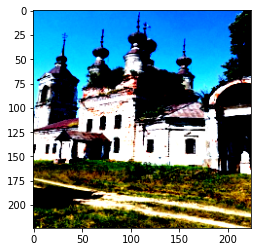

resnet18 prediction on raw_images/57.683622,36.969297.jpg
0.213 -> mosque/outdoor
0.203 -> mausoleum
0.175 -> church/outdoor
0.075 -> museum/outdoor
0.047 -> palace


In [134]:
img_name = 'raw_images/57.683622,36.969297.jpg'

centre_crop = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))

fig, ax = plt.subplots(1)
ax.imshow(centre_crop(img).permute(1,2,0))
plt.show()

logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

print('{} prediction on {}'.format(arch,img_name))
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

Оставляем только интересующие нас классы. Вручную формируем список из исходного. Основная причина - в исходных классах много специфичных мест и внутренностей помещений.

In [135]:
allowed_classes = [
    'airfield',
    'airport_terminal',
    'alley',
    'amusement_park',
    'apartment_building/outdoor',
    'athletic_field/outdoor',
    'badlands',
    'bamboo_forest',
    'barn',
    'bazaar/outdoor',
    'beach',
    'boardwalk',
    'boathouse',
    'botanical_garden',
    'bridge',
    'building_facade',
    'butte',
    'canal/natural',
    'canal/urban',
    'canyon',
    'cemetery',
    'church/outdoor',
    'cliff',
    'coast',
    'construction_site',
    'corn_field',
    'corral',
    'cottage',
    'creek',
    'crevasse',
    'crosswalk',
    'dam',
    'desert/sand',
    'desert/vegetation',
    'desert_road',
    'downtown',
    'driveway',
    'embassy',
    'farm',
    'field/cultivated',
    'field/wild',
    'field_road',
    'fishpond',
    'football_field',
    'forest/broadleaf',
    'forest_path',
    'forest_road',
    'formal_garden',
    'greenhouse/outdoor',
    'grotto',
    'hangar/outdoor',
    'harbor',
    'hayfield',
    'heliport',
    'highway',
    'house',
    'industrial_area',
    'islet',
    'lagoon',
    'lake/natural',
    'landfill',
    'lighthouse',
    'market/outdoor',
    'marsh',
    'mausoleum',
    'moat/water',
    'mosque/outdoor',
    'mountain',
    'mountain_path',
    'mountain_snowy',
    'oast_house',
    'ocean',
    'orchard',
    'park',
    'parking_garage/outdoor',
    'parking_lot',
    'pasture',
    'picnic_area',
    'pier',
    'pond',
    'promenade',
    'raceway',
    'rainforest',
    'river',
    'rope_bridge',
    'ruin',
    'runway',
    'schoolhouse',
    'skyscraper',
    'slum',
    'soccer_field',
    'street',
    'swamp',
    'tower',
    'train_station/platform',
    'trench',
    'tundra',
    'valley',
    'viaduct',
    'village',
    'waterfall',
    'wave',
    'wheat_field',
    'wind_farm',
    'windmill'
]

def check_place(img):
    image_tensor = V(centre_crop(img).unsqueeze(0))
    with torch.no_grad():
        logit = model.forward(image_tensor)
        h_x = F.softmax(logit, 1).data.squeeze()
        probs, idx = h_x.sort(0, True)
    if (np.sum(np.array(probs[0:3])) < 0.6):
        return False
    for i in range(3):
        if classes[idx[i]] not in allowed_classes:
            return False
    return True
    

### Модель для распознавания людей

Также используем стороннее решение - предобученную модель из библиотеки torchvision

In [136]:
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

resnet_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor()
])

img = Image.open(img_name)

img = transform(img)

resnet_model.eval()
with torch.no_grad():
    predictions = resnet_model([img])

print(predictions)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /tmp/xdg_cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 81.1MB/s]


[{'boxes': tensor([[652.3083,  12.4104, 800.0000, 481.9793]]), 'labels': tensor([64]), 'scores': tensor([0.0721])}]


In [137]:
def check_no_person(img):
    image_tensor = transform(img)
    with torch.no_grad():
        predictions = resnet_model([image_tensor])
        labels = np.array(predictions[0]['labels'])
        scores = np.array(predictions[0]['scores'])
    for label, score in zip(labels, scores):
        if label == 1 and score > 0.9:
            return False
    return True

### Фильтрация исходных изображений

Проверяем и перекладываем в папку images только изображения без людей, соответствующие интересующим классам.

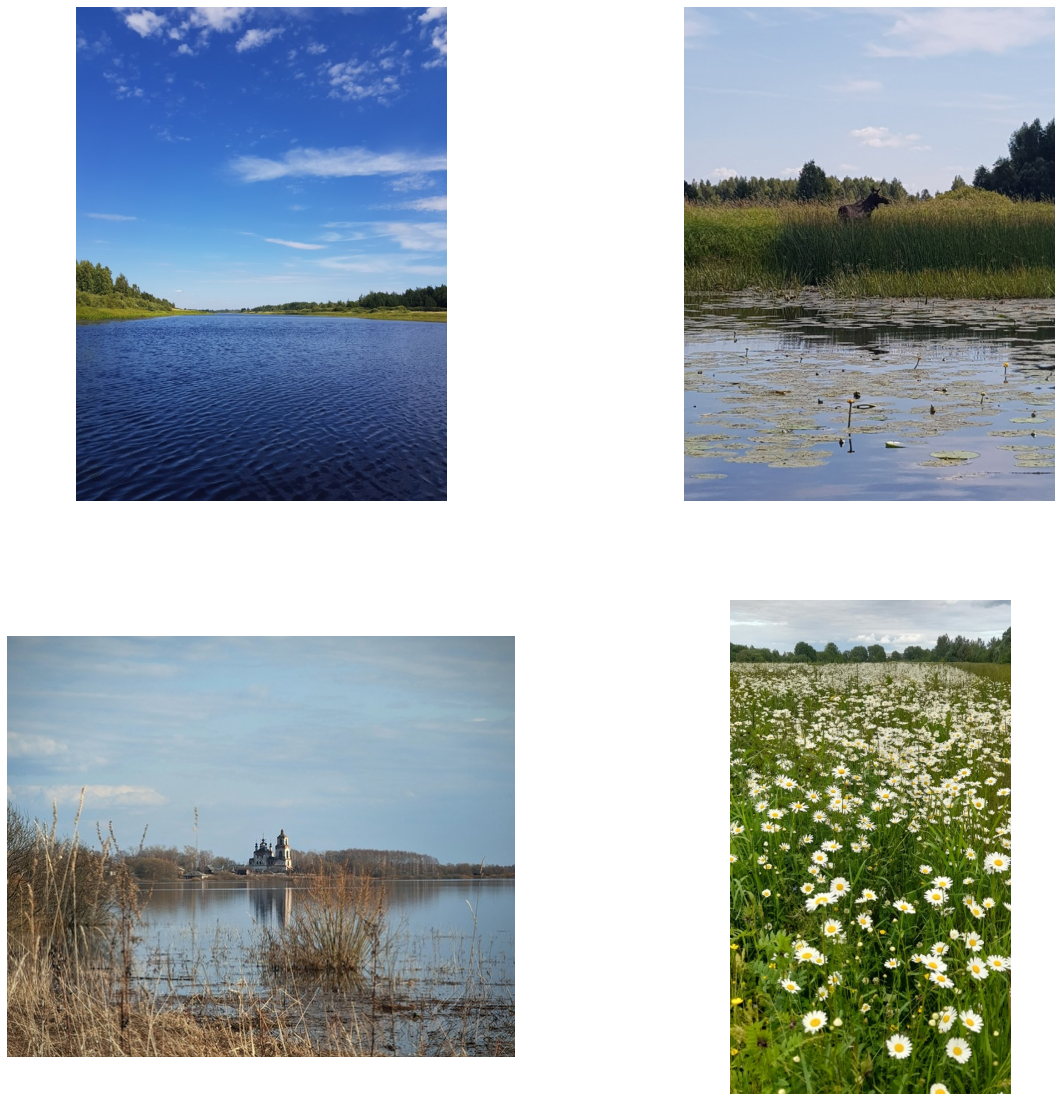

In [138]:
folder_path = './raw_images';
file_list = os.listdir(folder_path)

fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 2
count = 0
for file_name in file_list:
    if not file_name.endswith('.jpg'):
        continue
    
    image_path = os.path.join(folder_path, file_name)
    try:
        image = Image.open(image_path)
    except UnidentifiedImageError:
        continue

    if check_place(image) and check_no_person(image):
        count += 1
        fig.add_subplot(rows, columns, count)
        plt.imshow(image)
        plt.axis('off')
        if count == columns * rows:
            break
plt.show()


In [ ]:
import shutil

src_path = './raw_images';
dst_path = './images';
file_list = os.listdir(src_path)
print_count = 100

for i, file_name in enumerate(file_list):
    if not file_name.endswith('.jpg'):
        continue
    
    image_path = os.path.join(src_path, file_name)
    try:
        image = Image.open(image_path)
    except UnidentifiedImageError:
        print(f'Failed to open {file_name}')
        continue

    try:
        if check_place(image) and check_no_person(image):
            new_image_path = os.path.join(dst_path, file_name)
            shutil.copy(image_path, new_image_path)
    except Exception:
        print(f'Failed to process {file_name}')
        continue

Итого имеем готовые для обучения генератора пейзажные фотографии 